In [256]:
import numpy as np
%pylab inline
import matplotlib.pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [406]:
pwd

u'/Users/huskeypm'

In [407]:
Ccn = 50.0
#Kd1 = 1760
per_sec_to_per_ms =1 # Nevermind for now / 1e-3
K_dN = 1760.
k_f1 = 7.69e-6*per_sec_to_per_ms
k_r1 = 1.93e-2*per_sec_to_per_ms
k_f2 = 1.44e-3*per_sec_to_per_ms
k_f3 = 3.62e-4*per_sec_to_per_ms
k_r3 = 4.71e-5*per_sec_to_per_ms
k_f4 = 4.45e-4*per_sec_to_per_ms
K_mN = 535.
M = 6000.
n = 2.92
Ntot = 1000.
Ca = 100. # nM 
NFATp_c = 9.83e-1  # nM
NFATp_n = 2.76e-1
NFATN_c =1.70e-3
NFATN_n=5.09e-1

# J1 only
#k_f2=0; k_f3=0; k_r3=0; k_f4=0;

def ActN(Ca):
    act_N = np.power(Ca, n) / (np.power(Ca, n) + np.power(K_mN, n) * (1  + K_dN / M))
    return act_N

def Cooling(Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n):
    # fract activated N
    act_N = ActN(Ca)
    act_N = 1
    J1 = k_f1 * NFATp_c * Ntot * act_N - k_r1 * NFATN_c * (1 - act_N)
    J2 = k_f2 * NFATN_c
    J3 = k_f3 * NFATN_n * (1  - act_N) - k_r3 * NFATp_n * Ntot * act_N
    J4 = k_f4 * NFATp_n
    dNFATp_c_dt = J4 / Ccn - J1
    dNFATp_n_dt = J3 - J4
    dNFATN_c_dt = J1 - J2
    dNFATN_n_dt = J2 * Ccn - J3
    return dNFATp_c_dt,dNFATp_n_dt,dNFATN_c_dt,dNFATN_n_dt
#nuclearNFAT = NFATN_n + NFATp_n


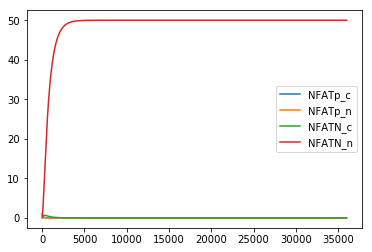

In [405]:
tsLong = np.linspace(0,60*600,36000) # 60s*60m 
y0=[500,NFATp_c,NFATp_n,NFATN_c,NFATN_n]
ys = odeint(dydt,y0,tsLong,args=(0,0))
Plotting(tsLong,ys)

In [397]:
print Cooling(1e-1, NFATp_c,NFATp_n,NFATN_c,NFATN_n)
print Cooling(100, NFATp_c,NFATp_n,NFATN_c,NFATN_n)
print Cooling(10000, NFATp_c,NFATp_n,NFATN_c,NFATN_n)

print ActN(1e-6 * 1e9) # Ca: 1 uM -> nM

(3.5266399923817144e-05, 6.1437999867706386e-05, -3.5257999923817145e-05, -6.1857999867706386e-05)
(-8.3205764289381051e-06, -1.4251996402628384e-05, 8.3289764289381032e-06, 1.3831996402628385e-05)
(-0.0075549135913018971, -0.013119120582070456, 0.0075549219913018965, 0.013118700582070457)
0.82767005246


#### Pulse train for Ca

In [550]:
# Create periodic exponential decay
def caSign(t,decay=10.,pulseAmplitude=700.,dom=20.):
    z = t/dom - np.floor(t/dom);
    z = pulseAmplitude*np.exp(-decay*z)
    return z

# Single rate 
def caRemove(t,rate=1.):
    return -rate
    
    
# Fermi dirac potential (behaves like a 'smooth' heavyside function)    
def fermiDirac(t,rate=1.,offset=50):
    ts = t-offset
    z = 1/(1 + np.exp(-ts*rate))
    return z

# creates a 'notch' by taking the difference of two fermidiracs
def notch(t,offset=50,deltaT=20):
    gr = fermiDirac(t,rate=1.,offset=offset)
    gl = fermiDirac(t,rate=1.,offset=offset+deltaT)
    g = gr -gl
    return g

# creates periodic signal with two phase decay
def caSignTwoPhase(t,decay1=1.,pulseAmplitude=700.,period=20.,
                     decay2=5.,phaseOffset=0.7):
    modulo = t/period - np.floor(t/period);
    firstPhase = pulseAmplitude*np.exp(-decay1*modulo)
    secondPhase= 1-fermiDirac(modulo,rate=decay2,offset=phaseOffset)
    result = firstPhase*secondPhase
    #z3 = z2
    return result


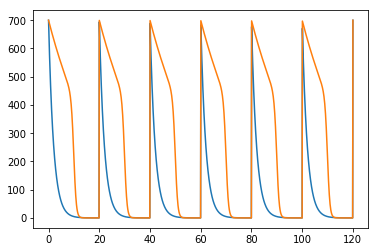

In [552]:
ts= np.linspace(0,120,1200)    
g = caSign(ts,pulseAmplitude=700.,decay=10.)    
plt.plot(ts,g)
g = caSignTwoPhase(ts,pulseAmplitude=700.,decay1=1.0,decay2=40.,phaseOffset=0.5)    
plt.plot(ts,g)
#plt.plot(ts,notch(ts))

#### Determine compensating flux for Ca removal 

In [351]:
dt = (ts[1]-ts[0])
caAdd = np.sum(g[0:199])*dt  # nM
Deltat = ts[199]-ts[0] # [s]
rate_nM_s = caAdd/Deltat # [nM/s]
rate_nM_ms= rate_nM_s/1000.
print rate_nM_ms

0.0720631833838


#### Integratation function

In [384]:
#  [Ca]
#Ca = 100 # nM 
#NFATp_c = 9.83e-1  # nM
#NFATp_n = 2.76e-1
#NFATN_c =1.70e-3
#NFATN_n=5.09e-1

y0=[Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n]
def dydt(y,t,removalRate,pulseAmplitude):
    # Ca
    dCa_dt = caSign(t,pulseAmplitude=pulseAmplitude)
    dCa_dt+= caRemove(t,rate=removalRate)
    
    Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n = y
    dNFATp_c_dt,dNFATp_n_dt,dNFATN_c_dt,dNFATN_n_dt =Cooling(
        Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n)
    return dCa_dt,dNFATp_c_dt,dNFATp_n_dt,dNFATN_c_dt,dNFATN_n_dt


In [382]:
def Plotting(ts,ys) :   
    #plt.plot(ts,ys[:,0],label= "Ca")

    plt.figure()
    plt.plot(ts,ys[:,1],label="NFATp_c")
    plt.plot(ts,ys[:,2],label="NFATp_n")
    plt.plot(ts,ys[:,3],label="NFATN_c")
    plt.plot(ts,ys[:,4],label="NFATN_n")
    plt.legend(loc=0)
    
    #plt.figure()
    Cas = ys[:,0]
    Nact = ActN(Cas)*Ntot
    #plt.plot(ts,Nact)
    

#### Ca removal offsets Ca entry

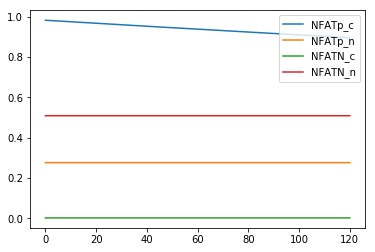

In [386]:
ys = odeint(dydt,y0,ts,args=(rate_nM_s*0.97,700))
Plotting(ts,ys)

In [355]:
#ys = odeint(dydt,y0,ts,args=(rate_nM_s*0.57,700))
#Plotting(ts,ys)

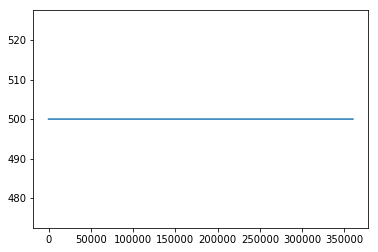

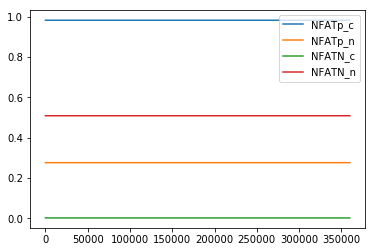

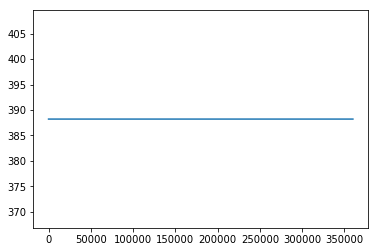

In [356]:
tsLong = np.linspace(0,60*6000,3600) # 60s*60m 
y0=[500,NFATp_c,NFATp_n,NFATN_c,NFATN_n]
ys = odeint(dydt,y0,tsLong,args=(0,0))
Plotting(tsLong,ys)